In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install bbox_visualizer -qq

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import model_selection

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import bbox_visualizer as bbv

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from glob import glob
from skimage import exposure

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings

warnings.filterwarnings('ignore')

In [ ]:
BASE_DIR = '/kaggle/input/splitdata/'


In [ ]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df.shape

(29057, 10)

In [ ]:
test_df = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))
test_df.shape

(3528, 10)

In [ ]:
val_df = pd.read_csv(os.path.join(BASE_DIR, 'val.csv'))
val_df.shape

(3511, 10)

In [ ]:
train_df['image_path'] = '/kaggle/input/vindr-cxr-normal/Normal/'+train_df.image_id+'.png'
train_df.tail(5)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
29052,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880,/kaggle/input/vindr-cxr-normal/Normal/b53d1dd8...
29053,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072,/kaggle/input/vindr-cxr-normal/Normal/26d1d5a0...
29054,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500,/kaggle/input/vindr-cxr-normal/Normal/22672ab8...
29055,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880,/kaggle/input/vindr-cxr-normal/Normal/db169d0b...
29056,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040,/kaggle/input/vindr-cxr-normal/Normal/4b56bc6d...


In [ ]:
test_df['image_path'] = '/kaggle/input/vindr-cxr-normal/Normal/'+test_df.image_id+'.png'
val_df['image_path'] = '/kaggle/input/vindr-cxr-normal/Normal/'+val_df.image_id+'.png'

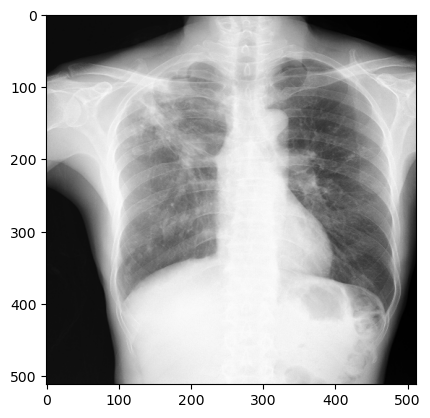

In [ ]:
plt.imshow(cv2.imread(val_df['image_path'][0]))

In [ ]:
IMG_SIZE = 512
train_df['xmin'] = (train_df['x_min']/train_df['width'])*IMG_SIZE
train_df['ymin'] = (train_df['y_min']/train_df['height'])*IMG_SIZE
train_df['xmax'] = (train_df['x_max']/train_df['width'])*IMG_SIZE
train_df['ymax'] = (train_df['y_max']/train_df['height'])*IMG_SIZE

In [ ]:
IMG_SIZE = 512
test_df['xmin'] = (test_df['x_min']/test_df['width'])*IMG_SIZE
test_df['ymin'] = (test_df['y_min']/test_df['height'])*IMG_SIZE
test_df['xmax'] = (test_df['x_max']/test_df['width'])*IMG_SIZE
test_df['ymax'] = (test_df['y_max']/test_df['height'])*IMG_SIZE

In [ ]:
IMG_SIZE = 512
val_df['xmin'] = (val_df['x_min']/val_df['width'])*IMG_SIZE
val_df['ymin'] = (val_df['y_min']/val_df['height'])*IMG_SIZE
val_df['xmax'] = (val_df['x_max']/val_df['width'])*IMG_SIZE
val_df['ymax'] = (val_df['y_max']/val_df['height'])*IMG_SIZE

In [ ]:
assert train_df['xmin'].all() <= IMG_SIZE
assert train_df['ymin'].all() <= IMG_SIZE
assert train_df['xmax'].all() <= IMG_SIZE
assert train_df['ymax'].all() <= IMG_SIZE

In [ ]:
class VBDDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):

        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # all the labels are shifted by 1 to accomodate background
        labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
TRAIN_DIR = '/kaggle/input/vindr-cxr-normal/Normal'

In [ ]:
dt = VBDDataset(train_df, TRAIN_DIR)
dt[0]

(array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.44705883, 0.44705883, 0.44705883],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.2901961 , 0.2901961 , 0.2901961 ],
         [0.30980393, 0.30980393, 0.30980

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(train_df, TRAIN_DIR, get_train_transform())
valid_dataset = VBDDataset(train_df, TRAIN_DIR, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
# device = torch.device('cuda')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
class_brands = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis'
}

In [ ]:
def plot_x_ray(idx,images,targets):
    boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
    labels = targets[idx]['labels']-1
    sample = images[idx].permute(1,2,0).cpu().numpy()

    img = sample.copy()
    plt.figure(figsize=(16, 8))
    for box,label in zip(boxes,labels):
        bbv.add_label(img, class_brands[label.item()], box,
                      draw_bg=True,
                      text_bg_color=(255,0,0),
                      text_color=(0,0,0),
                      )
        cv2.rectangle(img ,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (120,0,0), 3)

    plt.imshow(img)

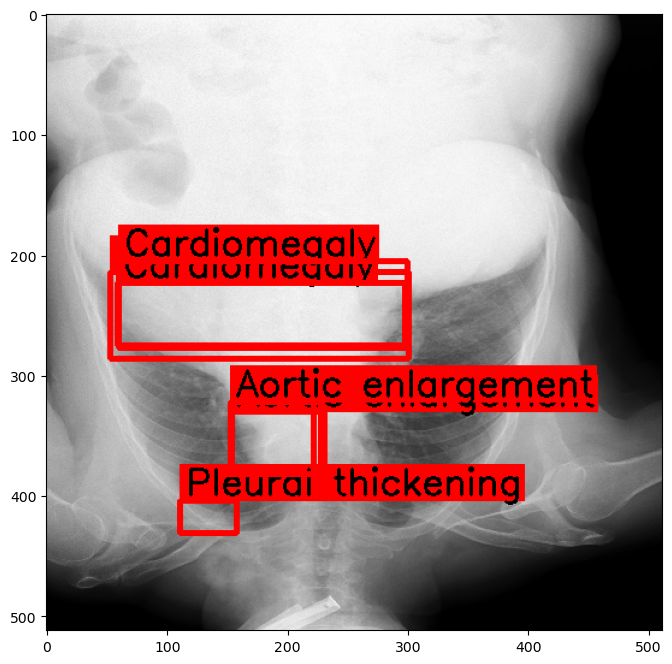

In [ ]:
plot_x_ray(1,images,targets) # hiển thị các loại bất thường kèm vị trí


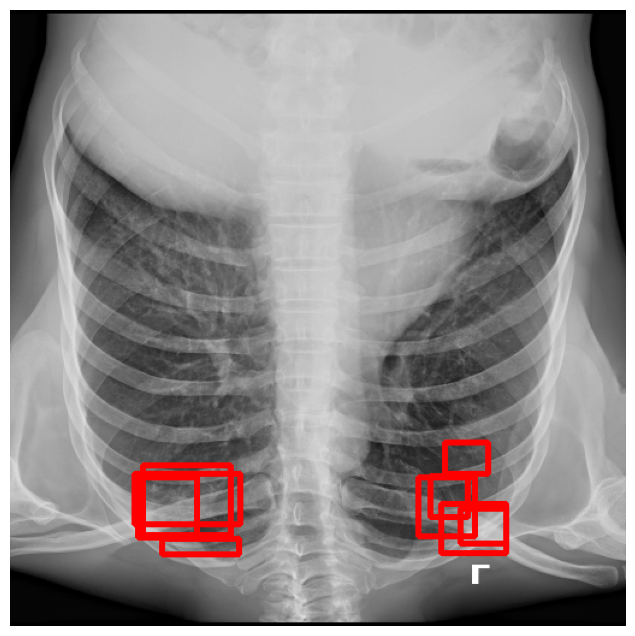

In [ ]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

In [ ]:
# Thay thế classifier bằng một trình phân loại mới, có num_classes do người dùng xác định
num_classes = 15  # 14 lớp + background

# tải một mô hình; được đào tạo trước về COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# nhận số lượng các đặc trưng đầu vào cho classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# thay thế đầu được đào tạo trước bằng một đầu mới của FastRcnn
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [ ]:
in_features

1024

In [ ]:
# hàm tính loss
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def plot_validation(idx, images, targets, predicted):
    boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
    labels = targets[idx]['labels']-1

    boxes_pred = predicted[idx]['boxes']#.detach().numpy().astype(np.int32)
    labels_pred = predicted[idx]['labels']-1
    scores = predicted[idx]['scores'].data.cpu().numpy()
    # Threshold: ngưỡng chấp nhận
    boxes_pred = boxes_pred[scores >= 0.2]

    sample = images[idx].permute(1,2,0).cpu().numpy()

    img = sample.copy() # tạo 1 mẫu bản sao
    plt.figure(figsize=(16, 16))

    for box,label in zip(boxes,labels):
        bbv.add_label(img, class_brands[label.item()], box,
                      draw_bg=True,
                      text_bg_color=(255,0,0),
                      text_color=(0,0,0),
                      )
        cv2.rectangle(img ,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (255,0,0), 3)
    for box,label in zip(boxes_pred,labels_pred):
        bbv.add_label(img, class_brands[label.item()], box,
                      draw_bg=True,
                      text_bg_color=(255, 255, 0), #đỏ
                      text_color=(0,0,0),
                      )
        cv2.rectangle(img ,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (255, 255, 0), 3) # vàng

    plt.imshow(img)
    plt.title('Vùng tin tưởng - Đỏ, Hộp đã dự đoán - Vàng',fontsize=14)

In [ ]:
def get_dataloaders(train, valid):

#     train_ = df.loc[trn_idx,:].reset_index(drop=True)
#     valid_ = df.loc[val_idx,:].reset_index(drop=True)

    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train, TRAIN_DIR, get_train_transform())
    valid_dataset = VBDDataset(valid, TRAIN_DIR, get_valid_transform())


    train_data_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    return train_data_loader, valid_data_loader

In [ ]:
def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):

    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset()

        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1

        # saving the model based on training loss for now. - later can be moved to validation
        if loss_hist.value < best_loss:
            best_loss = loss_hist.value
            torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")

    return all_losses


def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset()

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")


In [ ]:
import time

In [ ]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()



    trainloader, valloader = get_dataloaders(train_df, val_df)

    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold)

    # plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)
    plt.show()

    validate_model(model, valloader, device)

    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")


In [ ]:
model.to(device)

# set params for model
params = [p for p in model.parameters() if p.requires_grad]

# set optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# set lr scheduler
lr_scheduler = None

# set epochs
epochs = 20

# set folds
num_folds = 1

In [ ]:
for fold in range(num_folds):
    run_fold(fold)

In [ ]:
class_brands = {
    0: 'Aortic enlargement',
    1: 'Atelectasis',
    2: 'Calcification',
    3: 'Cardiomegaly',
    4: 'Consolidation',
    5: 'ILD',
    6: 'Infiltration',
    7: 'Lung Opacity',
    8: 'Nodule/Mass',
    9: 'Other lesion',
    10: 'Pleural effusion',
    11: 'Pleural thickening',
    12: 'Pneumothorax',
    13: 'Pulmonary fibrosis'
}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model.load_state_dict(torch.load('/kaggle/input/model-normal/fasterrcnn_model_0.pt', map_location=device)) # load lại model đã save ở trên
model.eval() #tắt các lớp như Dropouts Layers, BatchNorm Layers, v.v trong khi đánh giá mô hình

model.to(device) # chỉ cần chuyển đổi mô hình đã khởi tạo thành cpu or cuda tùy thuộc tham số trên
model.eval()
device = torch.device("cuda")

In [ ]:
class_dict = dict(set(zip(train_df.class_id, train_df.class_name)))
classes = []
for key in sorted(class_dict.keys()):
    classes.append(class_dict[key])

classes = ['_'] + classes   # adding background
classes

['_',
 'Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [ ]:
val_df = val_df.loc[val_df['image_id']=='1e8892e58834c2a38f8d0b574327ed81']

In [ ]:
val_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2304,2880,/kaggle/input/vindr-cxr-normal/Normal/d3637a19...
1,0a14aeaf02d42990d8bb5d55270b7274,ILD,5,R9,593.0,1597.0,1111.0,2207.0,2774,3043,/kaggle/input/vindr-cxr-normal/Normal/0a14aeaf...
2,ebf4ffbcf6de699bf9deab70f0dee8ff,Cardiomegaly,3,R9,876.0,1810.0,2336.0,2610.0,2779,2912,/kaggle/input/vindr-cxr-normal/Normal/ebf4ffbc...
3,eb6c714df22142229464c6b83e47d7d6,Infiltration,6,R8,439.0,1810.0,961.0,2452.0,2532,3073,/kaggle/input/vindr-cxr-normal/Normal/eb6c714d...
4,fa4c38b3c5e53e1e84bd0923f2d8e480,Aortic enlargement,0,R9,1397.0,849.0,1661.0,1200.0,2304,2880,/kaggle/input/vindr-cxr-normal/Normal/fa4c38b3...
...,...,...,...,...,...,...,...,...,...,...,...
3506,b6bb5088976d0d3d51f3041b2172cffb,Pulmonary fibrosis,13,R9,510.0,554.0,999.0,1108.0,2544,2828,/kaggle/input/vindr-cxr-normal/Normal/b6bb5088...
3507,b11960f23db725bb4ba6f6741586a5f7,Pleural thickening,11,R9,450.0,1726.0,605.0,1934.0,2540,3072,/kaggle/input/vindr-cxr-normal/Normal/b11960f2...
3508,c75f825862144dbdff940d9c4ecccde8,Aortic enlargement,0,R8,1550.0,608.0,1890.0,1053.0,2744,3036,/kaggle/input/vindr-cxr-normal/Normal/c75f8258...
3509,09b9674023305cb9a0acb367600efffa,Lung Opacity,7,R10,968.0,1020.0,1331.0,1385.0,3072,3072,/kaggle/input/vindr-cxr-normal/Normal/09b96740...


In [ ]:
valid_dataset = VBDDataset(val_df, TRAIN_DIR, get_valid_transform())
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

In [ ]:
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
targets

[{'boxes': tensor([[279.1667,  97.3495, 327.3333, 151.1480],
          [238.6667, 215.9257, 384.6667, 271.5540],
          [321.6667, 112.3545, 386.5000, 211.1680],
          [236.8333, 203.8485, 387.1667, 278.3245],
          [333.0000, 118.2102, 379.0000, 179.1451],
          [279.8333,  95.3367, 326.6667, 162.6762],
          [321.6667, 112.3545, 386.5000, 211.1680],
          [235.8333, 219.2194, 391.1667, 275.9457],
          [282.8333,  99.3624, 325.3333, 134.1301],
          [318.6667, 114.0014, 388.6667, 199.4568],
          [318.6667, 114.0014, 388.6667, 199.4568],
          [319.6667, 117.2952, 348.3333, 180.2430]], device='cuda:0',
         dtype=torch.float64),
  'labels': tensor([ 1,  4, 14,  4,  7,  1,  7,  4,  1,  7, 14,  5], device='cuda:0'),
  'image_id': tensor([0], device='cuda:0'),
  'area': tensor([ 2591.2910,  8121.7329,  6406.4048, 11196.2334,  2803.0078,  3153.7346,
           6406.4048,  8811.4746,  1477.6268,  5981.8726,  5981.8726,  1804.5042],
         devic

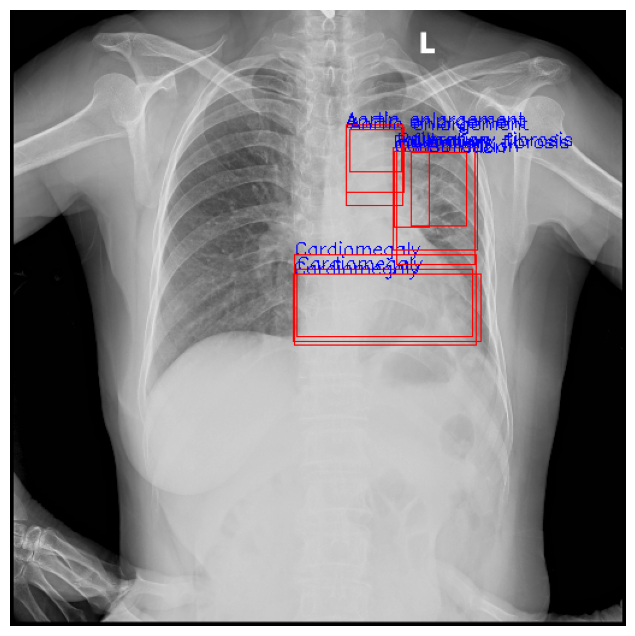

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
clss = targets[0]['labels'].cpu().numpy().astype(np.int32)

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box, clas in zip(boxes, clss):
    cv2.putText(sample, f"{classes[clas]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample)

In [ ]:
%cd '/kaggle/input/ds312src'

In [ ]:
!pip install pycocotools -qq

In [ ]:
test_df = pd.read_csv('/kaggle/input/splitdata/test.csv')

In [ ]:
IMG_SIZE = 512
test_df['xmin'] = (test_df['x_min']/test_df['width'])*IMG_SIZE
test_df['ymin'] = (test_df['y_min']/test_df['height'])*IMG_SIZE
test_df['xmax'] = (test_df['x_max']/test_df['width'])*IMG_SIZE
test_df['ymax'] = (test_df['y_max']/test_df['height'])*IMG_SIZE

In [ ]:
test_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,xmin,ymin,xmax,ymax
0,18a61a07e6f5f13ebfee57fa36cd8b6f,Pulmonary fibrosis,13,R9,393.0,283.0,822.0,643.0,2304,2880,87.333333,50.311111,182.666667,114.311111
1,d7aea6f37597df566725da73655edcc2,Infiltration,6,R8,1768.0,1137.0,2346.0,2020.0,2594,3395,348.965305,171.470987,463.050116,304.636230
2,0cfae3f740f87ca3b96dec765d06fad0,Aortic enlargement,0,R9,1142.0,738.0,1451.0,1119.0,2304,2880,253.777778,131.200000,322.444444,198.933333
3,b42e930c16c0166dbeae813b47bb8b07,Pleural thickening,11,R9,1972.0,401.0,2250.0,574.0,3072,3072,328.666667,66.833333,375.000000,95.666667
4,d07557904cbe57fc1bdebac1e8aeefa1,Nodule/Mass,8,R9,378.0,899.0,403.0,929.0,2304,2880,84.000000,159.822222,89.555556,165.155556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,7db70125d7739e6cd0c442e7b7592d4c,Other lesion,9,R10,92.0,999.0,374.0,3107.0,2961,3107,15.908139,164.624397,64.670044,512.000000
3524,970dcfd176e4fdaaf9bcb511a82e3b70,Infiltration,6,R9,1493.0,733.0,1707.0,902.0,2304,2880,331.777778,130.311111,379.333333,160.355556
3525,6ed469a35361b49e04971347281bc312,Aortic enlargement,0,R10,1113.0,867.0,1320.0,1116.0,2304,2880,247.333333,154.133333,293.333333,198.400000
3526,611077472d2fc78135ad2ad32059888e,Cardiomegaly,3,R9,756.0,1319.0,1673.0,1626.0,2304,2880,168.000000,234.488889,371.777778,289.066667


In [ ]:
class VBDDataset_TEST(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, idx):

        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0




        if self.transforms:
            sample = {
                'image': image
            }
            sample = self.transforms(**sample)
            image = sample['image']



        return image, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
test_dataset = VBDDataset_TEST(test_df, '/kaggle/input/vindr-cxr-process4/Process 4', get_test_transform())


test_data_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [ ]:
test_df.shape[0]

In [ ]:
test_iter = iter(test_data_loader)


In [ ]:
images, image_ids = next(test_iter)


In [ ]:
image_ids

In [ ]:
detection_threshold = 0.5
results = []

with torch.no_grad():

    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:

                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)

In [ ]:



len(results)

440

In [ ]:
result_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
result_df.head()

,image_id,PredictionString
0,18a61a07e6f5f13ebfee57fa36cd8b6f,14 1.0 0 0 1 1
1,d7aea6f37597df566725da73655edcc2,0 0.8221 184 116 262 183 3 0.7343 109 278 381 376
2,0cfae3f740f87ca3b96dec765d06fad0,3 0.8954 121 291 367 372 0 0.8001 191 93 249 1...
3,b42e930c16c0166dbeae813b47bb8b07,14 1.0 0 0 1 1
4,d07557904cbe57fc1bdebac1e8aeefa1,14 1.0 0 0 1 1


In [ ]:
result_df.loc[result_df['image_id']=='004f33259ee4aef671c2b95d54e4be68']

In [ ]:
result_df.to_csv('/kaggle/working/submission_pr4.csv', index=False)

In [ ]:
test_sub = pd.read_csv('/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/sample_submission.csv')

In [ ]:
test_sub.loc[test_sub['image_id']=='83caa8a85e03606cf57e49147d7ac569']